In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


In [2]:
df = pd.read_csv('diabetes.csv')
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [3]:
columns_with_zero_invalid = ['Glucose', 'BloodPressure', 'SkinThickness', 'BMI']

df[columns_with_zero_invalid] = df[columns_with_zero_invalid].replace(0, np.nan)

df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,763.000000,733.000000,541.000000,768.000000,757.000000,768.000000,768.000000,768.000000
mean,3.845052,121.686763,72.405184,29.153420,79.799479,32.457464,0.471876,33.240885,0.348958
std,3.369578,30.535641,12.382158,10.476982,115.244002,6.924988,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,7.000000,0.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,64.000000,22.000000,0.000000,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,29.000000,30.500000,32.300000,0.372500,29.000000,0.000000
75%,6.000000,141.000000,80.000000,36.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


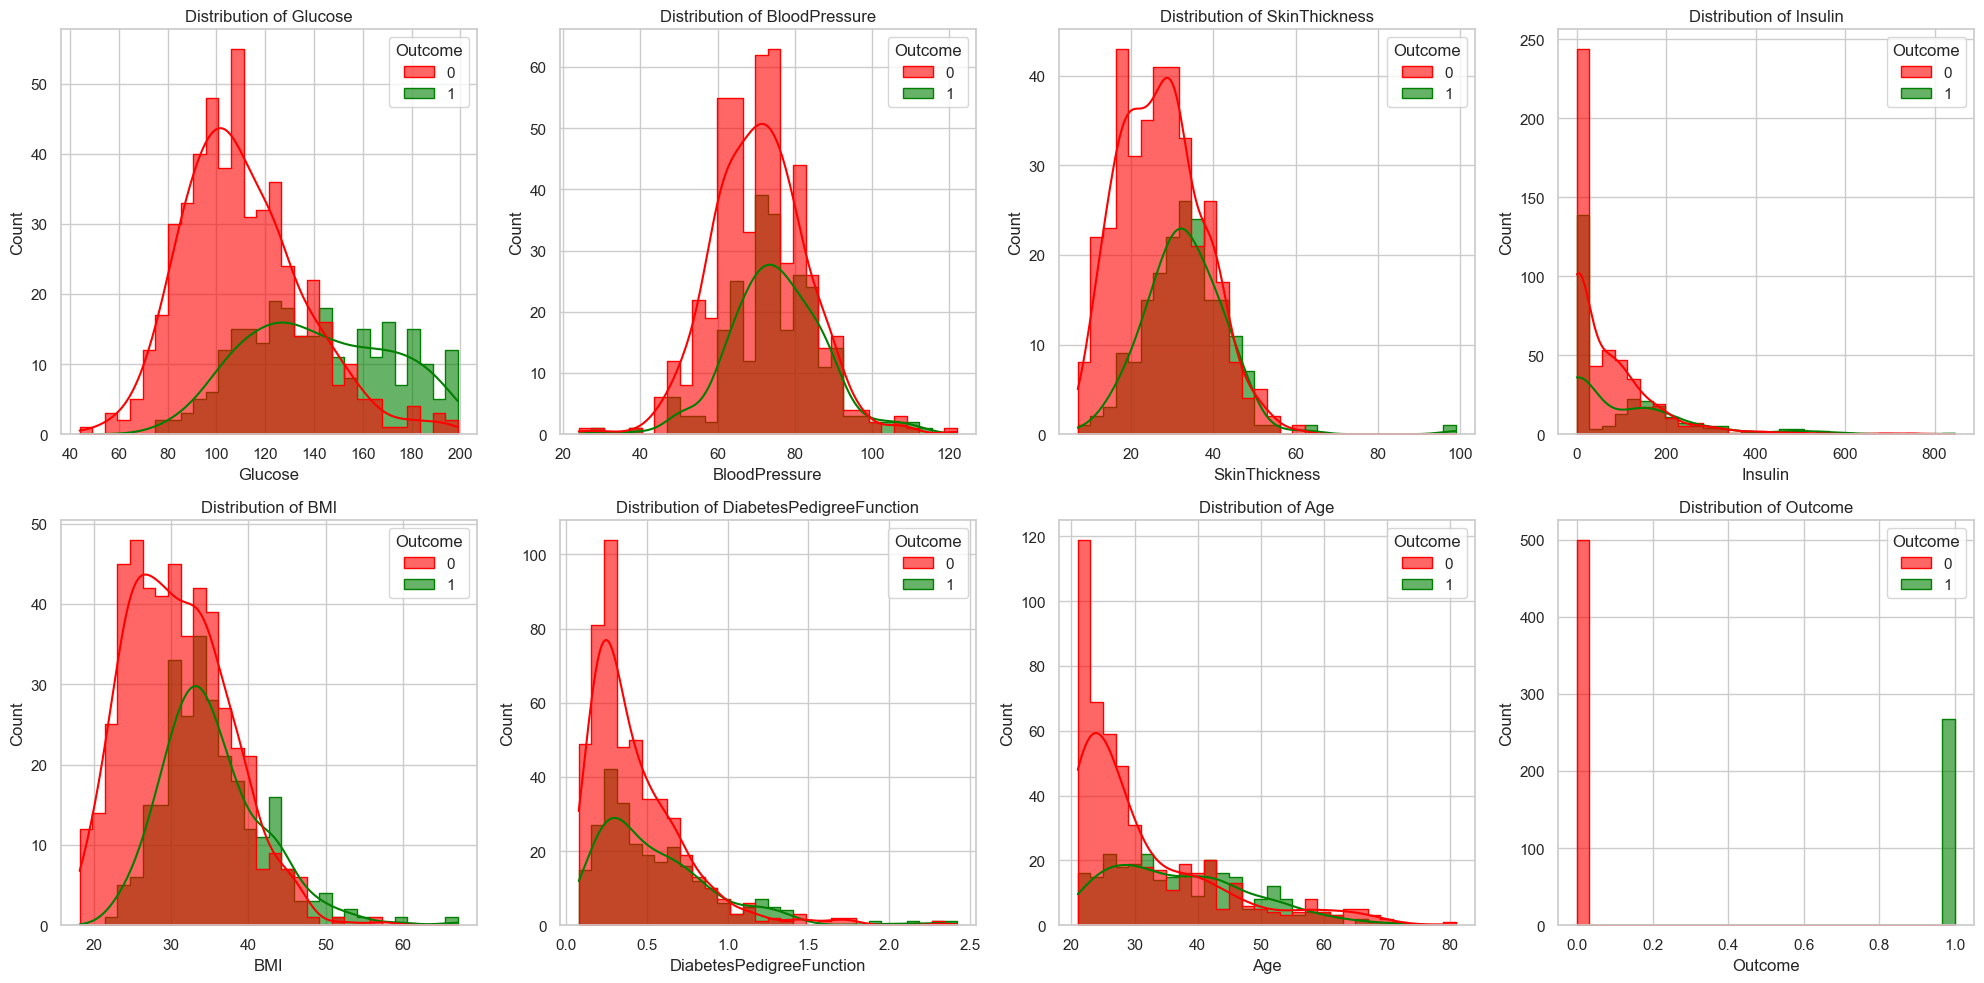

In [4]:
sns.set(style="whitegrid")

feature_columns = df.columns[1:]

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))

for i, feature in enumerate(feature_columns):
    row = i // 4
    col = i % 4
    
    sns.histplot(data=df, x=feature, hue="Outcome", kde=True, 
                 ax=axes[row, col], palette=['red', 'green'], bins=30, element='step', 
                 common_norm=False, stat="count", alpha=0.6)
    
    axes[row, col].set_title(f'Distribution of {feature}')

plt.tight_layout()
plt.show()

In [5]:
class Perceptron:
    def __init__(self, learning_rate, n_iter):
        self.lr = learning_rate
        self.n_iter = n_iter
        self.weights = None
        self.bias = None
        self.losses = []
    
    def _initialize_params(self, n_features):
        self.weights = np.zeros(n_features)
        self.bias = 0
    
    def _hinge_loss(self, X, y):
        loss = np.maximum(0, -y * (np.dot(X, self.weights) + self.bias))
        return np.mean(loss)
    
    def fit(self, X, y):
        n_samples, n_features = X.shape
        self._initialize_params(n_features)
        
        for _ in range(self.n_iter):
            for idx, x_i in enumerate(X):
                update = y[idx] * (np.dot(x_i, self.weights) + self.bias)
                if update <= 0:
                    self.weights += self.lr * y[idx] * x_i
                    self.bias += self.lr * y[idx]
            
            loss = self._hinge_loss(X, y)
            self.losses.append(loss)
    
    def predict(self, X):
        linear_output = np.dot(X, self.weights) + self.bias
        return np.where(linear_output >= 0, 1, -1)
    
    def plot_loss(self):
        plt.figure(figsize=(20, 9))
        plt.plot(range(self.n_iter), self.losses, label="Loss over iterations")
        plt.xlabel('Iterations')
        plt.ylabel('Loss')
        plt.title('Perceptron Loss')
        plt.legend()
        plt.show()

In [6]:
df.fillna(df.median(), inplace=True)
X = df.drop('Outcome', axis=1).values 
y = df['Outcome'].values
y = np.where(y == 1, 1, -1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234, stratify=y)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


Baseline Accuracy: 58.4416%


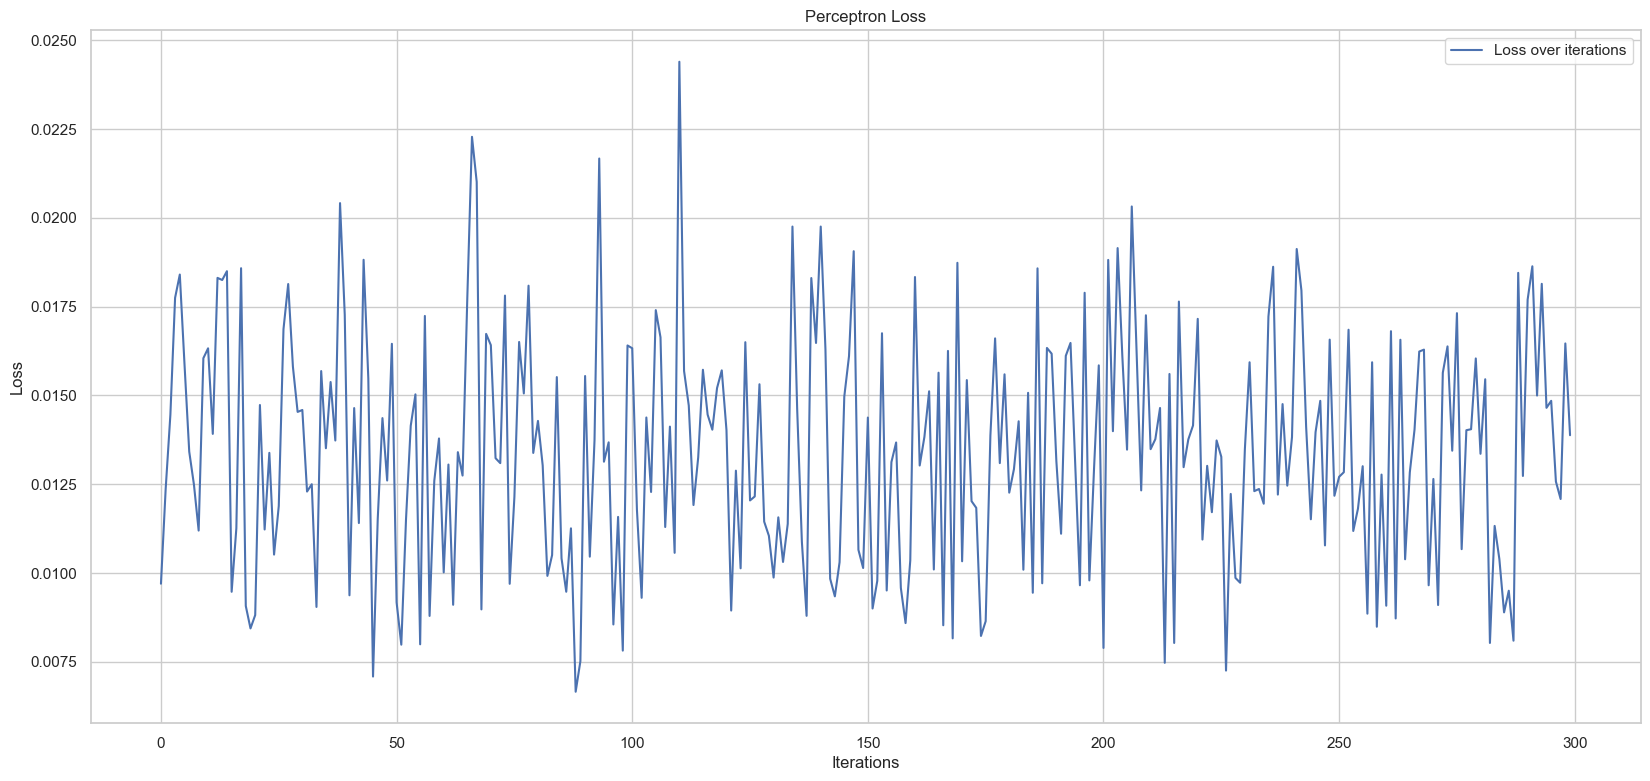

In [7]:
perceptron = Perceptron(learning_rate=0.01, n_iter=300)
perceptron.fit(X_train, y_train)
y_pred = perceptron.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Baseline Accuracy: {accuracy * 100:.4f}%")
perceptron.plot_loss()

In [8]:
def cross_validate_perceptron(X, y, learning_rates, n_iters, k=5):
    best_accuracy = 0
    best_params = {}
    kf = KFold(n_splits=k, shuffle=True, random_state=1234)
    
    for lr in learning_rates:
        for n_iter in n_iters:
            accuracies = []
            for train_index, val_index in kf.split(X):
                X_train_fold, X_val_fold = X[train_index], X[val_index]
                y_train_fold, y_val_fold = y[train_index], y[val_index]
                
                perceptron = Perceptron(learning_rate=lr, n_iter=n_iter)
                perceptron.fit(X_train_fold, y_train_fold)
                
                y_pred_fold = perceptron.predict(X_val_fold)
                accuracy = accuracy_score(y_val_fold, y_pred_fold)
                accuracies.append(accuracy)
            
            avg_accuracy = np.mean(accuracies)
            print(f"Learning rate: {lr}, Iterations: {n_iter}, Accuracy: {avg_accuracy * 100:.2f}%")
            
            if avg_accuracy > best_accuracy:
                best_accuracy = avg_accuracy
                best_params = {'learning_rate': lr, 'n_iter': n_iter}
    
    print(f"Best Parameters: {best_params}, Best Cross-Validation Accuracy: {best_accuracy * 100:.2f}%")
    return best_params

learning_rates = [0.001, 0.01, 0.1]
n_iters = [100, 300, 500, 1000]
best_params = cross_validate_perceptron(X_train, y_train, learning_rates, n_iters)

Learning rate: 0.001, Iterations: 100, Accuracy: 66.60%
Learning rate: 0.001, Iterations: 300, Accuracy: 65.78%
Learning rate: 0.001, Iterations: 500, Accuracy: 66.28%
Learning rate: 0.001, Iterations: 1000, Accuracy: 63.67%
Learning rate: 0.01, Iterations: 100, Accuracy: 66.60%
Learning rate: 0.01, Iterations: 300, Accuracy: 65.78%
Learning rate: 0.01, Iterations: 500, Accuracy: 66.28%
Learning rate: 0.01, Iterations: 1000, Accuracy: 63.67%
Learning rate: 0.1, Iterations: 100, Accuracy: 66.60%
Learning rate: 0.1, Iterations: 300, Accuracy: 65.78%
Learning rate: 0.1, Iterations: 500, Accuracy: 66.28%
Learning rate: 0.1, Iterations: 1000, Accuracy: 63.67%
Best Parameters: {'learning_rate': 0.001, 'n_iter': 100}, Best Cross-Validation Accuracy: 66.60%


In [9]:
class KernelPerceptron:
    def __init__(self, kernel='poly', learning_rate=1, n_iter=10, **kwargs):
        self.kernel = kernel
        self.lr = learning_rate
        self.n_iter = n_iter
        self.alpha = None
        self.X_train = None
        self.y_train = None
        self.losses = []
        self.train_accuracies = []
        self.test_accuracies = []
        self.params = kwargs  

    def _kernel_function(self, x1, x2):
        if self.kernel == 'poly':
            degree = self.params.get('degree', 3)
            coef0 = self.params.get('coef0', 1)
            return (np.dot(x1, x2) + coef0) ** degree
        elif self.kernel == 'rbf':
            gamma = self.params.get('gamma', 0.1)
            diff = x1 - x2
            return np.exp(-gamma * np.dot(diff, diff))
        else:
            raise ValueError("Error")

    def fit(self, X_train, y_train, X_test=None, y_test=None):
        n_samples = X_train.shape[0]
        self.alpha = np.zeros(n_samples)
        self.X_train = X_train
        self.y_train = y_train

        K = np.zeros((n_samples, n_samples))
        for i in range(n_samples):
            for j in range(n_samples):
                K[i, j] = self._kernel_function(X_train[i], X_train[j])

        for epoch in range(self.n_iter):
            error_count = 0
            for i in range(n_samples):
                y_pred = np.sign(np.sum(self.alpha * self.y_train * K[:, i]))
                if y_pred == 0:
                    y_pred = 1 
                if y_pred != y_train[i]:
                    self.alpha[i] += self.lr
                    error_count += 1
            self.losses.append(error_count)
            train_accuracy = self._calculate_accuracy(K, y_train)
            self.train_accuracies.append(train_accuracy)
            if X_test is not None and y_test is not None:
                test_accuracy = self.score(X_test, y_test)
                self.test_accuracies.append(test_accuracy)
        if self.test_accuracies:
            max_test_accuracy = max(self.test_accuracies)
            best_iteration = self.test_accuracies.index(max_test_accuracy) + 1
            print(f"Best test accuracy achieved: {max_test_accuracy:.4f} at iteration {best_iteration}")
        else:
            max_train_accuracy = max(self.train_accuracies)
            best_iteration = self.train_accuracies.index(max_train_accuracy) + 1
            print(f"Best training accuracy achieved: {max_train_accuracy:.4f} at iteration {best_iteration}")

    def _calculate_accuracy(self, K, y_true):
        n_samples = y_true.shape[0]
        y_pred = np.zeros(n_samples)
        for i in range(n_samples):
            output = np.sign(np.sum(self.alpha * self.y_train * K[:, i]))
            if output == 0:
                output = 1  
            y_pred[i] = output
        accuracy = np.mean(y_pred == y_true)
        return accuracy

    def predict(self, X):
        y_pred = []
        for x in X:
            sum_k = 0
            for i in range(len(self.alpha)):
                sum_k += self.alpha[i] * self.y_train[i] * self._kernel_function(self.X_train[i], x)
            output = np.sign(sum_k)
            if output == 0:
                output = 1  
            y_pred.append(output)
        return np.array(y_pred)

    def score(self, X, y):
        y_pred = self.predict(X)
        accuracy = np.mean(y_pred == y)
        return accuracy

    def plot_loss_accuracy(self):
        iterations = range(1, self.n_iter + 1)

        fig, ax1 = plt.subplots(figsize=(20, 9))

        color = 'tab:red'
        ax1.set_xlabel('Iterations')
        ax1.set_ylabel('Loss (Misclassifications)', color=color)
        ax1.plot(iterations, self.losses, color=color, label='Loss')
        ax1.tick_params(axis='y', labelcolor=color)
        ax1.legend(loc='upper left')

        ax2 = ax1.twinx()  
        color = 'tab:blue'
        ax2.set_ylabel('Accuracy', color=color)
        ax2.plot(iterations, self.train_accuracies, color=color, label='Train Accuracy')
        if self.test_accuracies:
            ax2.plot(iterations, self.test_accuracies, color='tab:green', label='Test Accuracy')
        ax2.tick_params(axis='y', labelcolor=color)
        ax2.legend(loc='upper right')

        plt.title('Kernel Perceptron Loss and Accuracy over Iterations')
        plt.show()


Best training accuracy achieved: 0.8795 at iteration 260


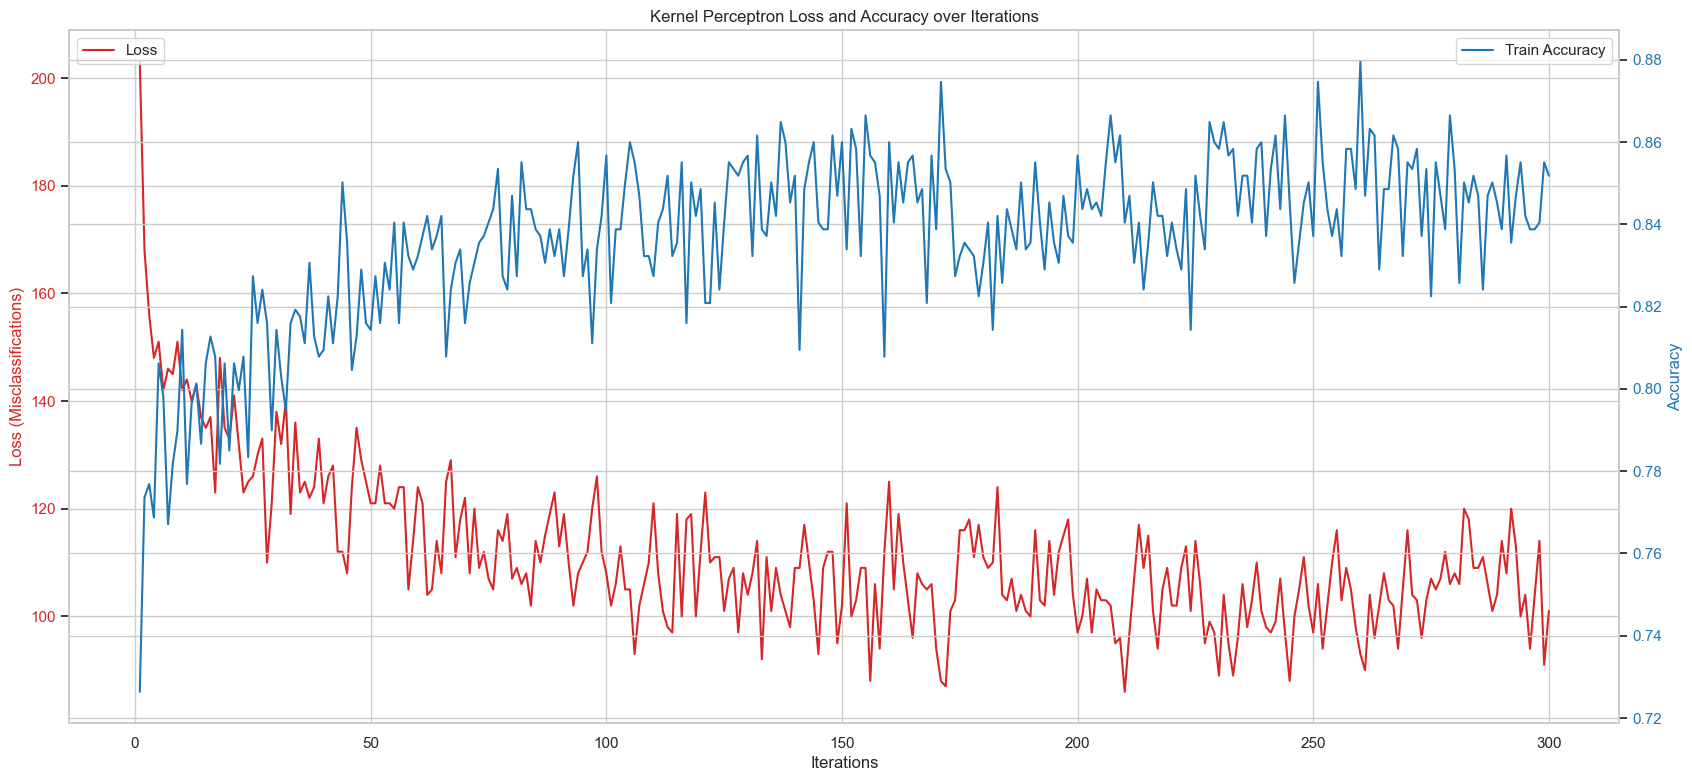

In [10]:
kp_poly = KernelPerceptron(kernel='poly', learning_rate=0.01, n_iter=300, degree=3, coef0=1)
kp_poly.fit(X_train, y_train)
kp_poly.plot_loss_accuracy()

In [11]:
y_pred_poly = kp_poly.predict(X_test)
test_accuracy = kp_poly.score(X_test, y_test)
print(f"Test accuracy with polynomial kernel: {test_accuracy:.4f}")

Test accuracy with polynomial kernel: 0.7338


Best training accuracy achieved: 0.9544 at iteration 290


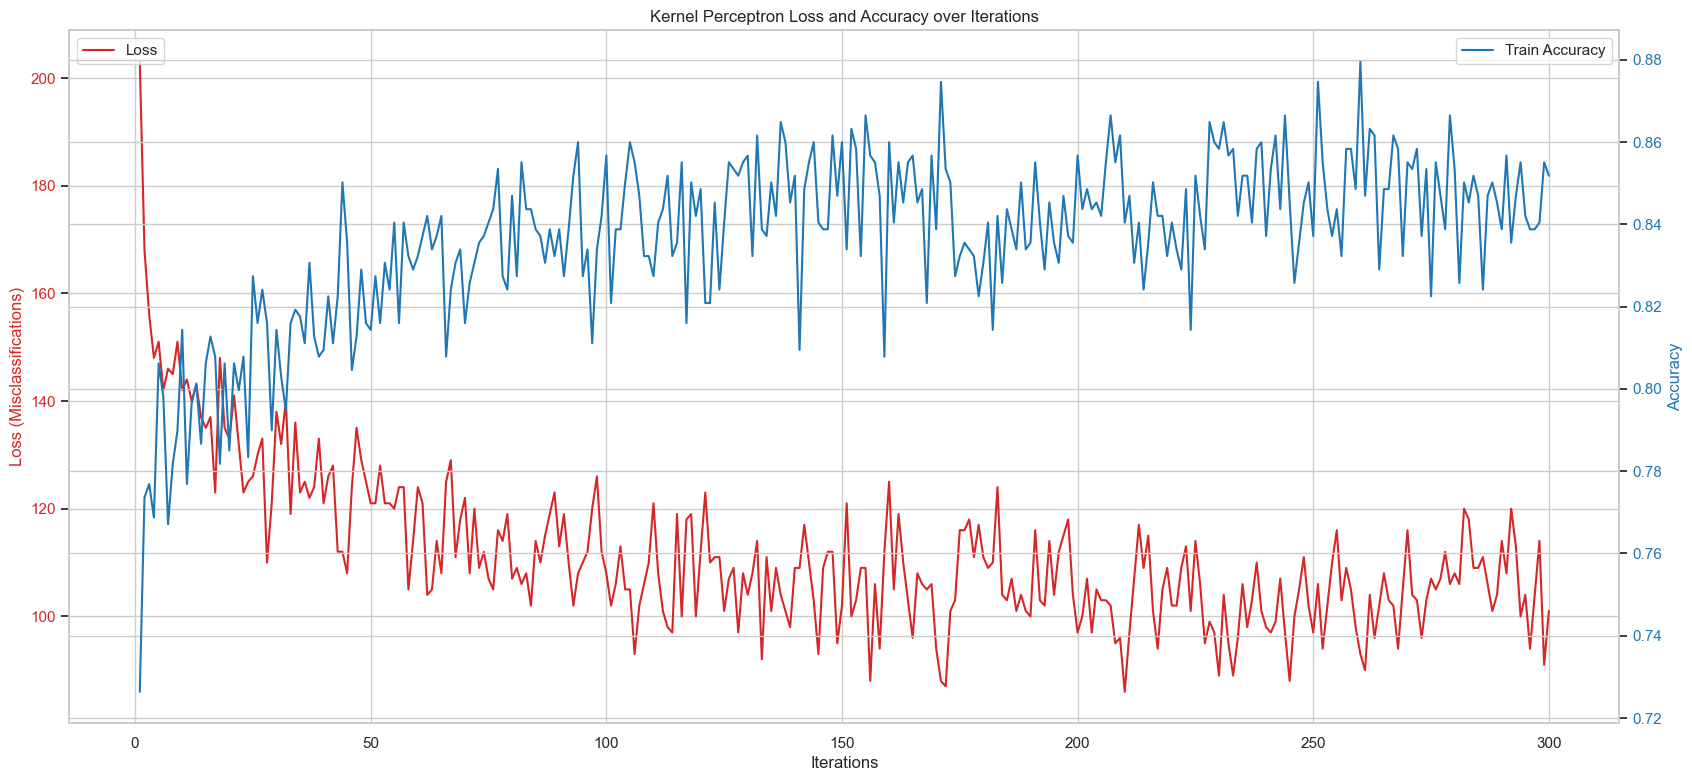

In [12]:
kp_rbf = KernelPerceptron(kernel='rbf', learning_rate=0.01, n_iter=300, gamma=0.1)
kp_rbf.fit(X_train, y_train)
kp_poly.plot_loss_accuracy()

In [13]:
y_pred_rbf = kp_rbf.predict(X_test)
test_accuracy = kp_rbf.score(X_test, y_test)
print(f"Test accuracy with RBF kernel: {test_accuracy:.4f}")

Test accuracy with RBF kernel: 0.7013
